In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools

# Dumificamos las variables y hacemos protocolo de evaluación 

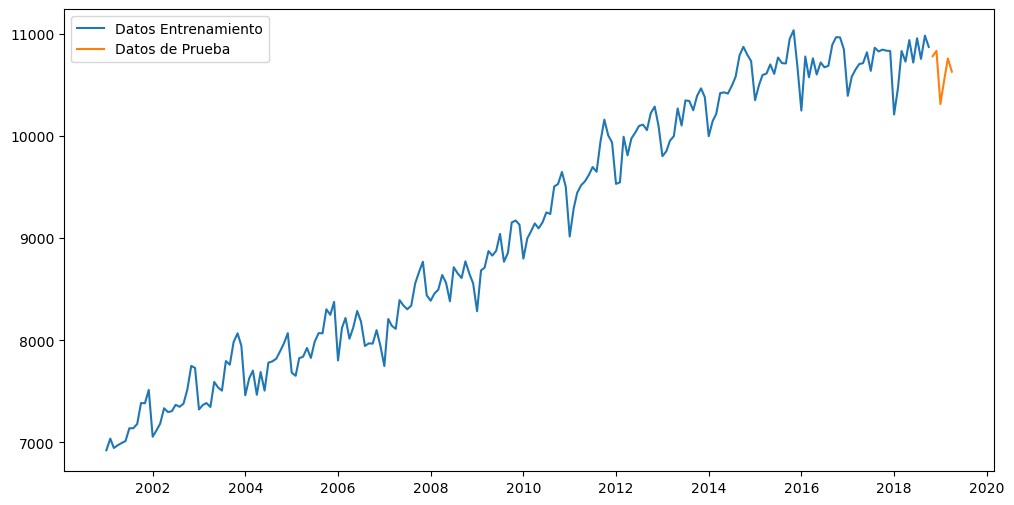

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)
month_dummies = month_dummies.astype(float) # para arreglar el problema de casteo
month_dummies = pd.concat([data, month_dummies], axis=1)# Añadir las variables dummy al final del DataFrame original


#Dividimos el dataset en train y test, considerando 6 meses a predecir
train_data = month_dummies.iloc[:-6]
test_data = month_dummies.iloc[-6:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_data["Ocupados"],label="Datos Entrenamiento")
plt.plot(test_data["Ocupados"],label="Datos de Prueba")
plt.legend()
plt.show()

# Comparativo de modelos desde grado 1 (Regresión lineal) hasta grado 10, sin considerar y considerando estacionalidad.

In [3]:
# Inicializar una lista para almacenar los resultados
rmse_results = []

for grado in range(1, 11):
    # Modelo sin estacionalidad
    y_train = train_data["Ocupados"]
    x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
    X_train = np.vander(x_train, N=grado+1)
    
    lin = sm.OLS(y_train, X_train)
    lin_t = lin.fit()

    y_test = test_data["Ocupados"]
    x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
    X_test = np.vander(x_test, N=grado+1)

    y_pred = lin_t.predict(X_test)
    rmse_sin_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred))

    # Modelo con estacionalidad
    X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)
    lin_season = sm.OLS(y_train, X_train_season)
    lin_t_season = lin_season.fit()

    X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)
    y_pred_season = lin_t_season.predict(X_test_season)
    rmse_con_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred_season))

    # Almacenar los resultados en la lista
    rmse_results.append({
        'Grado': grado,
        'Sin Estacionalidad': rmse_sin_estacionalidad,
        'Con Estacionalidad': rmse_con_estacionalidad
    })

# Convertir la lista de resultados en un DataFrame
rmse_results_df = pd.DataFrame(rmse_results)

# Mostrar la tabla de resultados
rmse_results_df


,Grado,Sin Estacionalidad,Con Estacionalidad
0,1,718.651675,657.508980
1,2,646.597813,590.479496
2,3,238.469108,130.743939
3,4,222.843611,221.621692
4,5,219.947167,91.006689
5,6,337.129999,225.178930
6,7,3709.346672,3709.348872
7,8,6086.663086,6086.663089
8,9,8655.081671,8655.081671
9,10,13431.660407,13431.660407


El mejor modelo de acuerdo con el protocolo de evaluación es una regresión de grado 5 con estacionalidad, observamos el comparativo de la predicción vs los datos reales:

Coeficientes del modelo (Betas):
x1       8.625089e-08
x2      -5.370993e-05
x3       1.120143e-02
x4      -8.958470e-01
x5       4.223479e+01
const    6.588641e+03
x6       1.712018e+02
x7       2.353168e+02
x8       2.374569e+02
x9       2.967677e+02
x10      2.555894e+02
x11      3.310670e+02
x12      3.052980e+02
x13      3.643789e+02
x14      4.742364e+02
x15      4.924690e+02
x16      3.906222e+02
dtype: float64


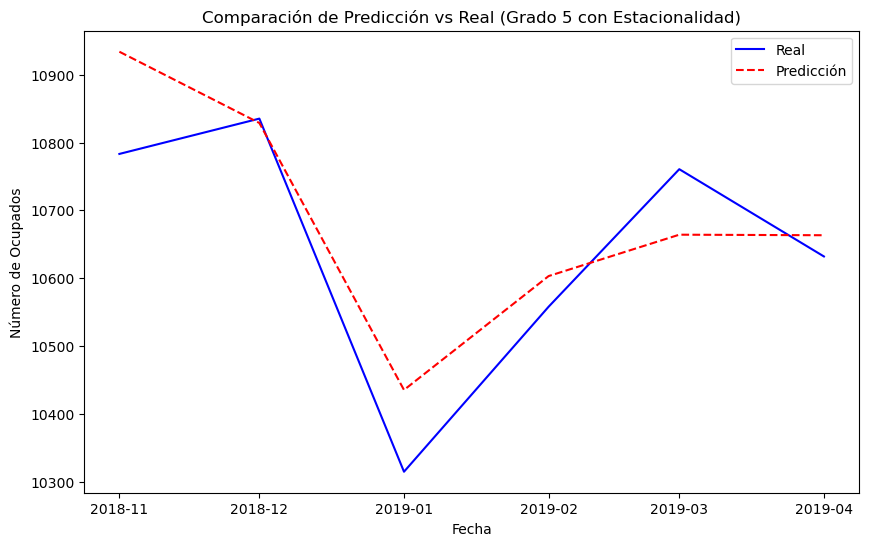

In [4]:
# Mejor modelo: Grado 5 con estacionalidad
grado = 5

# Preparar las variables para el modelo
y_train = train_data["Ocupados"]
x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
X_train = np.vander(x_train, N=grado+1)

# Añadir las variables dummy (estacionalidad)
X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)

# Ajustar el modelo de regresión lineal polinómico con estacionalidad
lin_season = sm.OLS(y_train, X_train_season)
lin_t_season = lin_season.fit()

# Preparar los datos de prueba
y_test = test_data["Ocupados"]
x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
X_test = np.vander(x_test, N=grado+1)
X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)


# Obtener los coeficientes (betas) del modelo
betas = lin_t_season.params

# Mostrar los betas
print("Coeficientes del modelo (Betas):")
print(betas)

# Realizar la predicción
y_pred_season = lin_t_season.predict(X_test_season)

# Gráfico de Predicción vs Real
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Real', color='blue')
plt.plot(test_data.index, y_pred_season, label='Predicción', color='red', linestyle='--')
plt.title('Comparación de Predicción vs Real (Grado 5 con Estacionalidad)')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

            Ocupados   Predicción
mes                              
2001-01-01  6923.604  6629.991243
2001-02-01  7037.746  6840.817935
2001-03-01  6945.973  6942.897760
2001-04-01  6973.079  6981.406827
2001-05-01  6994.462  7075.553469


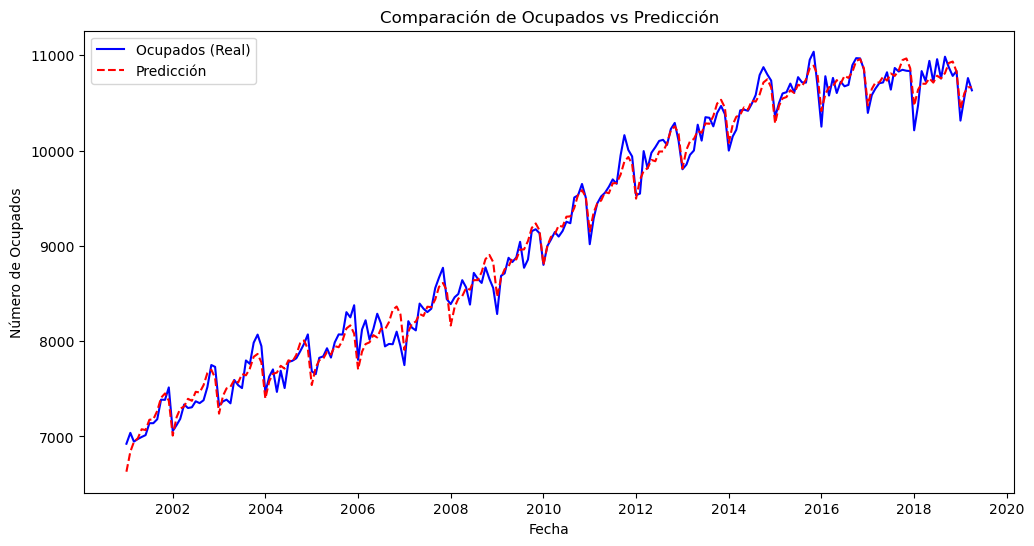

In [5]:
# Preparar las variables para todo el dataset (220 datos)
x_full = np.linspace(1, len(month_dummies), len(month_dummies))
X_full = np.vander(x_full, N=grado+1)

# Añadir las variables dummy (estacionalidad)
X_full_season = np.concatenate([X_full, month_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores
y_pred_full = np.dot(X_full_season, betas)

# Añadir las predicciones al DataFrame original
month_dummies['Predicción'] = y_pred_full

# Mostrar las primeras filas del DataFrame con la predicción
print(month_dummies[['Ocupados', 'Predicción']].head())

# Generar el gráfico de "Ocupados" vs "Predicción"
plt.figure(figsize=(12, 6))
plt.plot(month_dummies.index, month_dummies['Ocupados'], label='Ocupados (Real)', color='blue')
plt.plot(month_dummies.index, month_dummies['Predicción'], label='Predicción', color='red', linestyle='--')
plt.title('Comparación de Ocupados vs Predicción')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

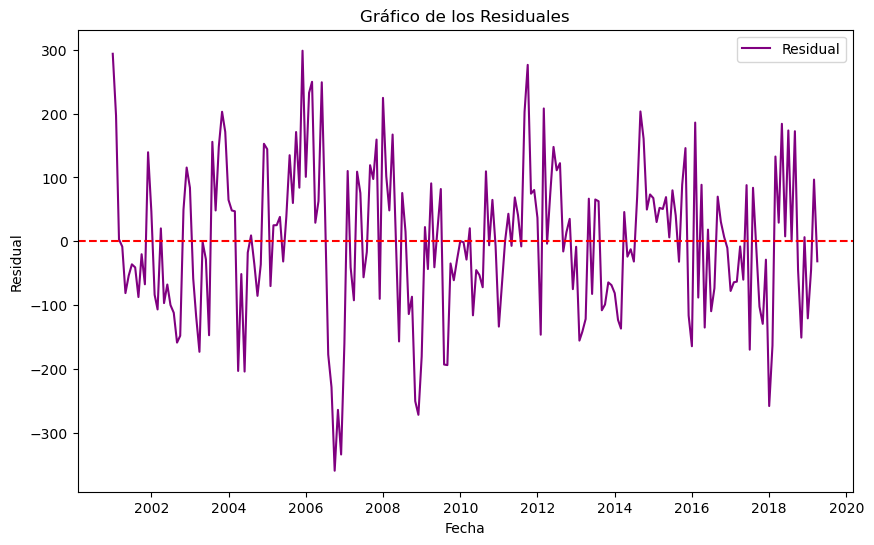

In [6]:
# Calcular los residuales
month_dummies['Residual'] = month_dummies['Ocupados'] - month_dummies['Predicción']

# Graficar los residuales
plt.figure(figsize=(10, 6))
plt.plot(month_dummies.index, month_dummies['Residual'], label='Residual', color='purple')
plt.title('Gráfico de los Residuales')
plt.xlabel('Fecha')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.show()

# Realizamos la predicción para los proximos 6 meses

            Ocupados    Predicción
2001-01-01  6923.604   6629.991243
2001-02-01  7037.746   6840.817935
2001-03-01  6945.973   6942.897760
2001-04-01  6973.079   6981.406827
2001-05-01  6994.462   7075.553469
...              ...           ...
2019-06-01       NaN  10676.125441
2019-07-01       NaN  10749.267581
2019-08-01       NaN  10721.437533
2019-09-01       NaN  10778.769244
2019-10-01       NaN  10887.228117

[226 rows x 2 columns]


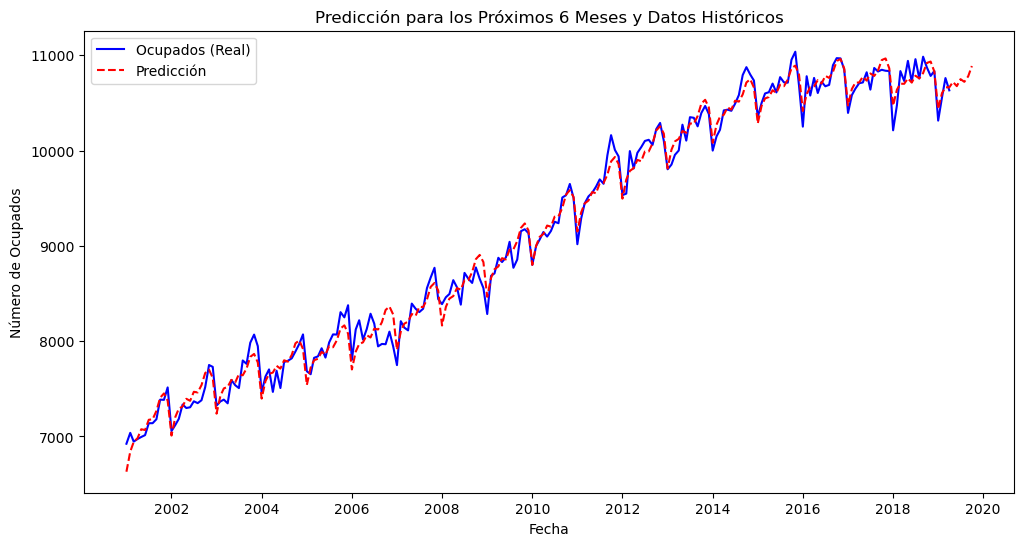

In [32]:
# Paso 1: Extender el dataset original para incluir los próximos 6 meses

# Obtener el índice del último mes del dataset original
start_date = data.index[-1] + MonthBegin(1)

# Generar las nuevas fechas, que serán el primer día de cada mes
new_dates = pd.date_range(start=start_date, periods=6, freq='MS')

# Crear un DataFrame vacío para las nuevas filas
new_data = pd.DataFrame(index=new_dates, columns=data.columns)

# Concatenar las nuevas filas al dataset original
data_extended = pd.concat([data, new_data])

# Paso 2: Dumificar las nuevas fechas

# Crear las variables dummy para todo el dataset extendido (incluyendo los nuevos meses)
month_dummies = pd.get_dummies(data_extended.index.month, drop_first=True).set_index(data_extended.index)
month_dummies = month_dummies.astype(float)

# Paso 3: Concatenar las dummies al dataset extendido
data_extended_with_dummies = pd.concat([data_extended, month_dummies], axis=1)

# Paso 4: Realizar la predicción utilizando el modelo ajustado

# Preparar las variables para la predicción futura
x_future = np.linspace(1, len(data_extended_with_dummies), len(data_extended_with_dummies))
X_future = np.vander(x_future, N=grado+1)

# Añadir las variables dummy (estacionalidad) a las variables futuras
X_future_season = np.concatenate([X_future, data_extended_with_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores futuros
y_pred_future = np.dot(X_future_season, betas)

# Añadir las predicciones al DataFrame extendido
data_extended_with_dummies['Predicción'] = y_pred_future

# Mostrar las primeras filas del DataFrame extendido con la predicción
print(data_extended_with_dummies[['Ocupados', 'Predicción']])

# Graficar las predicciones para todo el periodo, incluyendo los próximos 6 meses
plt.figure(figsize=(12, 6))
plt.plot(data_extended_with_dummies.index, data_extended_with_dummies['Ocupados'], label='Ocupados (Real)', color='blue')
plt.plot(data_extended_with_dummies.index, data_extended_with_dummies['Predicción'], label='Predicción', color='red', linestyle='--')
plt.title('Predicción para los Próximos 6 Meses y Datos Históricos')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()